In [62]:
import logging
import re
from typing import Literal, Annotated

import numpy as np
import numpy.typing as npt
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
from tqdm import tqdm
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.DEBUG)
logger = logging.getLogger('base')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = 650
pd.options.display.max_rows = 20

# Load data

In [63]:
files = list(Path('../data/results/').glob('simulation-*.csv'))
lst = []
for fp in files:
    print(fp, end='  ->  ')
    lst.append(pd.read_csv(fp))
    print(lst[-1].shape)
    
df = pd.concat(lst)
# df = pd.read_csv('../data/results/results.csv')
print(df.shape)
print(list(df.columns))
df.head()

../data/results/simulation-APRIORI.csv  ->  (204824, 20)
../data/results/simulation-BUSCAR.csv  ->  (109360, 20)
../data/results/simulation-QUANT_CI.csv  ->  (614472, 21)
../data/results/simulation-METHOD2399.csv  ->  (153618, 22)
../data/results/simulation-BATCHPRECISION.csv  ->  (460854, 20)
../data/results/simulation-HEURISTIC_SCORES.csv  ->  (204824, 20)
../data/results/simulation-ALISON.csv  ->  (196496, 22)
../data/results/simulation-HEURISTIC_FIX.csv  ->  (204824, 18)
../data/results/simulation-KNEE.csv  ->  (614472, 23)
../data/results/simulation-HEURISTIC_RANDOM.csv  ->  (210244, 19)
../data/results/simulation-HEURISTIC_FRAC.csv  ->  (256030, 19)
(3230018, 43)
['dataset', 'sim-rep', 'sim_key', 'batch_i', 'n_total', 'n_seen', 'n_unseen', 'n_incl', 'n_incl_seen', 'n_incl_batch', 'n_records_batch', 'method', 'safe_to_stop', 'method-hash', 'method-KEY', 'method-safe_to_stop', 'method-score', 'method-recall_target', 'method-inclusion_threshold', 'method-est_recall', 'method-bias', 

,dataset,sim-rep,sim_key,batch_i,n_total,n_seen,n_unseen,n_incl,n_incl_seen,n_incl_batch,n_records_batch,method,safe_to_stop,method-hash,method-KEY,method-safe_to_stop,method-score,method-recall_target,method-inclusion_threshold,method-est_recall,method-bias,method-confidence_level,method-nstd,method-est_var,method-alpha,method-constant,method-num_reviewed,method-num_relevant_reviewed,method-threshold,method-batch_size,method-current_precision,method-est_incl,method-n_windows,method-expected_includes,method-curve_estimate,method-num_to_stop,method-window_size,method-polyorder,method-threshold_ratio,method-threshold_peak,method-slope_ratio,method-smoothing,method-fraction
0,clef-CD005139,2,clef-CD005139-0-500-2-best,0,4564,15,4549,105,0,0,15,APRIORI,False,APRIORI-f2879eb555b2b71aee4681ff5073424d4fd03b5a,APRIORI,False,NaN,0.80,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,clef-CD005139,2,clef-CD005139-0-500-2-best,0,4564,15,4549,105,0,0,15,APRIORI,False,APRIORI-6820479463a81f5ec984ee2a6db0def447fa8f5a,APRIORI,False,NaN,0.90,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,clef-CD005139,2,clef-CD005139-0-500-2-best,0,4564,15,4549,105,0,0,15,APRIORI,False,APRIORI-6698d1534b63eccb1e6945b6ed9551e36124b222,APRIORI,False,NaN,0.95,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,clef-CD005139,2,clef-CD005139-0-500-2-best,0,4564,15,4549,105,0,0,15,APRIORI,False,APRIORI-ef7582f2d6287119bcac527072f319480a44f13c,APRIORI,False,NaN,0.99,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,clef-CD005139,2,clef-CD005139-0-500-2-best,1,4564,30,4534,105,2,2,15,APRIORI,False,APRIORI-f2879eb555b2b71aee4681ff5073424d4fd03b5a,APRIORI,False,NaN,0.80,0.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
len(df['dataset'].unique())

86

<Axes: >

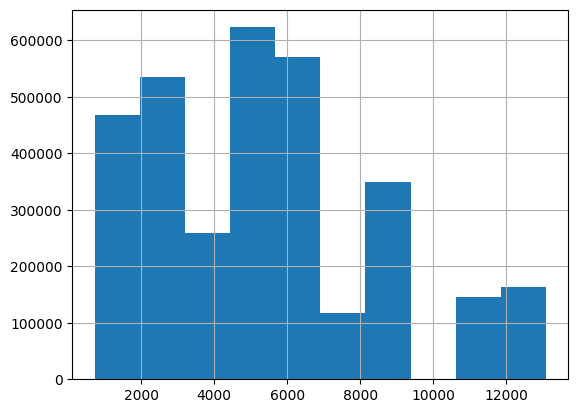

In [65]:
df['n_total'].hist()

In [66]:
results = []
RECALL_TARGETS = [0.8, 0.85, 0.9, 0.95, 0.99, 1.0]
for (hash_ranker, hash_method, repeat), sub_df in tqdm(df.groupby(['sim_key', 'method-hash', 'sim-rep'])):
    simulation = sub_df.sort_values(by=['batch_i'])
    simulation = simulation.where(simulation['dataset'].notna())
    rel_curve = simulation['n_incl_seen'] / simulation['n_incl']
    
    #info = simulation.iloc[0]
    #logger.info(f'Dataset "{info['dataset']}" stopped by "{info['method']}" (repeat {repeat} via {hash_method} / {hash_ranker})')
    stop_rows = simulation[simulation['safe_to_stop']]
    stop_row = (stop_rows.iloc[0] if  len(stop_rows) > 0 else simulation.iloc[-1]).to_dict()

    for t in RECALL_TARGETS:
        step = np.argwhere(rel_curve >= t).min()
        stop_row[f'seen@recall={t}'] = simulation.iloc[step]['n_seen']
        stop_row[f'unseen@recall={t}'] = simulation.iloc[step]['n_unseen']
        stop_row[f'seen_incl@recall={t}'] = simulation.iloc[step]['n_incl_seen']
        
        stop_row[f'too_late@recall={t}'] = max(0, stop_row['n_seen'] - simulation.iloc[step]['n_seen'])
        stop_row[f'too_late_left%@recall={t}'] = max(0, stop_row['n_seen'] - simulation.iloc[step]['n_seen']) / (simulation.iloc[step]['n_seen'])
        stop_row[f'too_late_right%@recall={t}'] = max(0, stop_row['n_seen'] - simulation.iloc[step]['n_seen']) / (stop_row['n_total'] - simulation.iloc[step]['n_seen'])
        
        stop_row[f'too_early@recall={t}'] = max(0, simulation.iloc[step]['n_seen'] - stop_row['n_seen'])
        stop_row[f'too_early%@recall={t}'] = -max(0, simulation.iloc[step]['n_seen'] - stop_row['n_seen']) / (simulation.iloc[step]['n_seen'])

        stop_row[f'missed@recall={t}'] =  max(0, simulation.iloc[step]['n_incl_seen'] - stop_row['n_incl_seen'])
        stop_row[f'missed%@recall={t}'] =  -max(0, simulation.iloc[step]['n_incl_seen'] - stop_row['n_incl_seen']) / stop_row['n_incl']

    results.append(stop_row)

df_res = pd.DataFrame(results)
df_res['stop_recall'] = df_res['n_incl_seen'] / df_res['n_incl']
df_res['work_saved'] = df_res['n_unseen'] / df_res['n_total']
df_res['incl_missed'] = (df_res['n_incl'] - df_res['n_incl_seen']) / df_res['n_incl']

for t in RECALL_TARGETS:
    df_res[f'tetl_left@recall={t}'] = df_res[[f'too_early%@recall={t}', f'too_late_left%@recall={t}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100
    df_res[f'tetl_right@recall={t}'] = df_res[[f'too_early%@recall={t}', f'too_late_right%@recall={t}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100
    df_res[f'mtl_right@recall={t}'] = df_res[[f'missed%@recall={t}', f'too_late_right%@recall={t}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100
    df_res[f'mtl_left@recall={t}'] = df_res[[f'missed%@recall={t}', f'too_late_left%@recall={t}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100
    df_res[f'missed_%@recall={t}'] = df_res[f'missed%@recall={t}'] * -100

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13773/13773 [02:50<00:00, 80.61it/s]


# Basic tests

In [67]:
len(df.groupby(['sim_key', 'method-hash', 'sim-rep']))

13773

In [68]:
for (hash_ranker, hash_method, repeat), sub_df in df.groupby(['sim_key', 'method-hash', 'sim-rep']):
    simulation = sub_df.sort_values(by=['batch_i'])
    info = simulation.iloc[0]
    logger.info(f'Dataset "{info['dataset']}" stopped by "{info['method']}" (repeat {repeat} via {hash_method} / {hash_ranker})')
    for _, step in simulation.iterrows():
        recall = step['n_incl_seen'] / step['n_incl']

        logger.info(f'Batch {step['batch_i']}: {step['n_seen']:,}/{step['n_total']:,} seen; '
              f'{step['n_incl_seen']:,}/{step['n_incl']:,} includes found; '
              f'recall={recall:.2%} | safe to stop: {step['safe_to_stop']}')

    logger.info('---')
    break

2025-06-20 02:57:46,931 [INFO] base: Dataset "clef-CD005139" stopped by "ALISON" (repeat 1 via ALISON-417e55e2a26d7f24cad8370396678f36024acb8f / clef-CD005139-0-500-1-best)
2025-06-20 02:57:46,933 [INFO] base: Batch 0: 15/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-06-20 02:57:46,934 [INFO] base: Batch 1: 30/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-06-20 02:57:46,934 [INFO] base: Batch 2: 45/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-06-20 02:57:46,935 [INFO] base: Batch 3: 60/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-06-20 02:57:46,936 [INFO] base: Batch 4: 75/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-06-20 02:57:46,937 [INFO] base: Batch 5: 90/4,564 seen; 0/105 includes found; recall=0.00% | safe to stop: False
2025-06-20 02:57:46,937 [INFO] base: Batch 6: 105/4,564 seen; 1/105 includes found; recall=0.95% | safe to stop: False


In [8]:
print(list(df_res.columns))
df_res.head()

['dataset', 'sim-rep', 'sim_key', 'batch_i', 'n_total', 'n_seen', 'n_unseen', 'n_incl', 'n_incl_seen', 'n_incl_batch', 'n_records_batch', 'method', 'safe_to_stop', 'method-hash', 'method-KEY', 'method-safe_to_stop', 'method-score', 'method-recall_target', 'method-inclusion_threshold', 'method-est_recall', 'method-bias', 'method-confidence_level', 'method-nstd', 'method-est_var', 'method-alpha', 'method-constant', 'method-num_reviewed', 'method-num_relevant_reviewed', 'method-threshold', 'method-batch_size', 'method-current_precision', 'method-est_incl', 'method-n_windows', 'method-expected_includes', 'method-curve_estimate', 'method-num_to_stop', 'method-window_size', 'method-polyorder', 'method-threshold_ratio', 'method-threshold_peak', 'method-slope_ratio', 'method-smoothing', 'method-fraction', 'seen@recall=0.8', 'unseen@recall=0.8', 'seen_incl@recall=0.8', 'too_late@recall=0.8', 'too_late_left%@recall=0.8', 'too_late_right%@recall=0.8', 'too_early@recall=0.8', 'too_early%@recall=0.

,dataset,sim-rep,sim_key,batch_i,n_total,n_seen,n_unseen,n_incl,n_incl_seen,n_incl_batch,n_records_batch,method,safe_to_stop,method-hash,method-KEY,method-safe_to_stop,method-score,method-recall_target,method-inclusion_threshold,method-est_recall,method-bias,method-confidence_level,method-nstd,method-est_var,method-alpha,method-constant,method-num_reviewed,method-num_relevant_reviewed,method-threshold,method-batch_size,method-current_precision,method-est_incl,method-n_windows,method-expected_includes,method-curve_estimate,method-num_to_stop,method-window_size,method-polyorder,method-threshold_ratio,method-threshold_peak,method-slope_ratio,method-smoothing,method-fraction,seen@recall=0.8,unseen@recall=0.8,seen_incl@recall=0.8,too_late@recall=0.8,too_late_left%@recall=0.8,too_late_right%@recall=0.8,too_early@recall=0.8,too_early%@recall=0.8,missed@recall=0.8,missed%@recall=0.8,seen@recall=0.85,unseen@recall=0.85,seen_incl@recall=0.85,too_late@recall=0.85,too_late_left%@recall=0.85,too_late_right%@recall=0.85,too_early@recall=0.85,too_early%@recall=0.85,missed@recall=0.85,missed%@recall=0.85,seen@recall=0.9,unseen@recall=0.9,seen_incl@recall=0.9,too_late@recall=0.9,too_late_left%@recall=0.9,too_late_right%@recall=0.9,too_early@recall=0.9,too_early%@recall=0.9,missed@recall=0.9,missed%@recall=0.9,seen@recall=0.95,unseen@recall=0.95,seen_incl@recall=0.95,too_late@recall=0.95,too_late_left%@recall=0.95,too_late_right%@recall=0.95,too_early@recall=0.95,too_early%@recall=0.95,missed@recall=0.95,missed%@recall=0.95,seen@recall=0.99,unseen@recall=0.99,seen_incl@recall=0.99,too_late@recall=0.99,too_late_left%@recall=0.99,too_late_right%@recall=0.99,too_early@recall=0.99,too_early%@recall=0.99,missed@recall=0.99,missed%@recall=0.99,seen@recall=1.0,unseen@recall=1.0,seen_incl@recall=1.0,too_late@recall=1.0,too_late_left%@recall=1.0,too_late_right%@recall=1.0,too_early@recall=1.0,too_early%@recall=1.0,missed@recall=1.0,missed%@recall=1.0,stop_recall,work_saved,incl_missed,tetl_left@recall=0.8,tetl_right@recall=0.8,mtl_right@recall=0.8,mtl_left@recall=0.8,missed_%@recall=0.8,tetl_left@recall=0.85,tetl_right@recall=0.85,mtl_right@recall=0.85,mtl_left@recall=0.85,missed_%@recall=0.85,tetl_left@recall=0.9,tetl_right@recall=0.9,mtl_right@recall=0.9,mtl_left@recall=0.9,missed_%@recall=0.9,tetl_left@recall=0.95,tetl_right@recall=0.95,mtl_right@recall=0.95,mtl_left@recall=0.95,missed_%@recall=0.95,tetl_left@recall=0.99,tetl_right@recall=0.99,mtl_right@recall=0.99,mtl_left@recall=0.99,missed_%@recall=0.99,tetl_left@recall=1.0,tetl_right@recall=1.0,mtl_right@recall=1.0,mtl_left@recall=1.0,missed_%@recall=1.0
0,clef-CD005139,1,clef-CD005139-0-500-1-best,304,4564,4564,0,105,105,0,15,ALISON,False,ALISON-417e55e2a26d7f24cad8370396678f36024acb8f,ALISON,False,NaN,0.99,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,900,3664,86,3664,4.071111,1.000000,0,0.0,0,0.0,960,3604,90,3604,3.754167,1.000000,0,0.0,0,0.0,1140,3424,96,3424,3.003509,1.000000,0,0.0,0,0.0,1545,3019,100,3019,1.954045,1.000000,0,0.0,0,0.0,2565,1999,104,1999,0.779337,1.000000,0,0.0,0,0.0,3465,1099,105,1099,0.317172,1.000000,0,0.0,0,0.0,1.0,0.000000,0.0,407.111111,100.000000,100.000000,407.111111,-0.0,375.416667,100.000000,100.000000,375.416667,-0.0,300.350877,100.000000,100.000000,300.350877,-0.0,195.404531,100.000000,100.000000,195.404531,-0.0,77.933723,100.000000,100.000000,77.933723,-0.0,31.717172,100.000000,100.000000,31.717172,-0.0
1,clef-CD005139,1,clef-CD005139-0-500-1-best,230,4564,3465,1099,105,105,1,15,ALISON,True,ALISON-502d519a5da2e428cb4ae83cc327d8199a4e6e28,ALISON,True,NaN,0.80,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,131.0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,900,3664,86,2565,2.850000,0.700055,0,0.0,0,0.0,960,3604,90,2505,2.609375,0.695061,0,0.0,0,0.0,1140,3424,96,2325,2.039474,0.679030,0,0.0,0,0.0,1545,3019,100,1920,1.242718,0.635972,0,0.0,0,0.0,2565,1999,104,900,0.350877,0.450225,0,0.0,0,0.0,3465,109

In [9]:
%matplotlib inline

<Axes: >

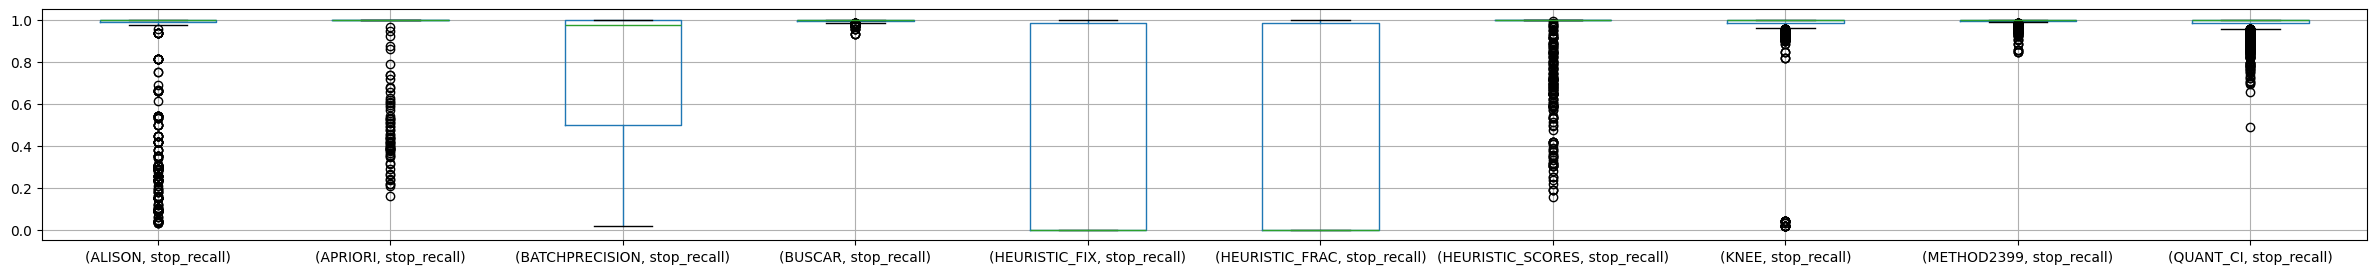

In [33]:
df_res.groupby('method').boxplot(subplots=False, column='stop_recall',  orientation='vertical', figsize=(30, 3))

<Axes: >

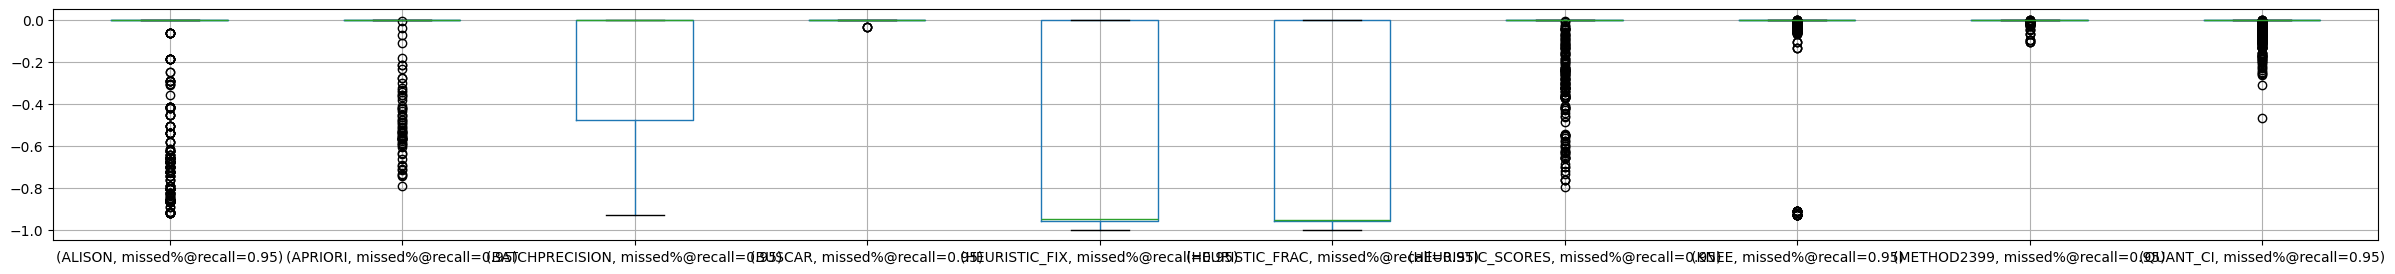

In [11]:
df_res.groupby('method').boxplot(subplots=False, column='missed%@recall=0.95', figsize=(30, 3))

<Axes: >

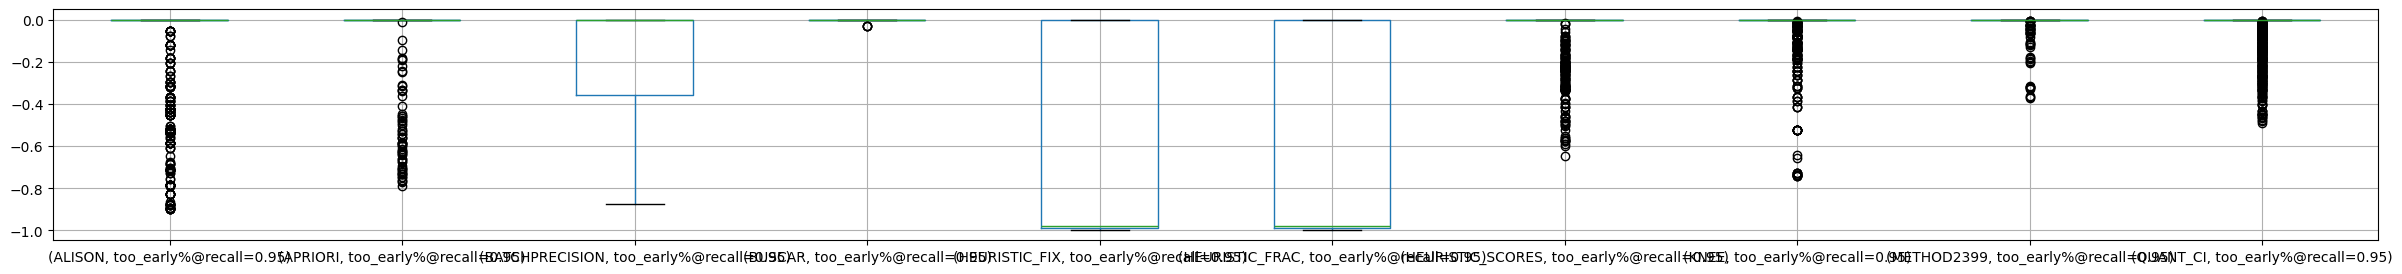

In [12]:
df_res.groupby('method').boxplot(subplots=False, column='too_early%@recall=0.95', figsize=(30, 3))

<Axes: >

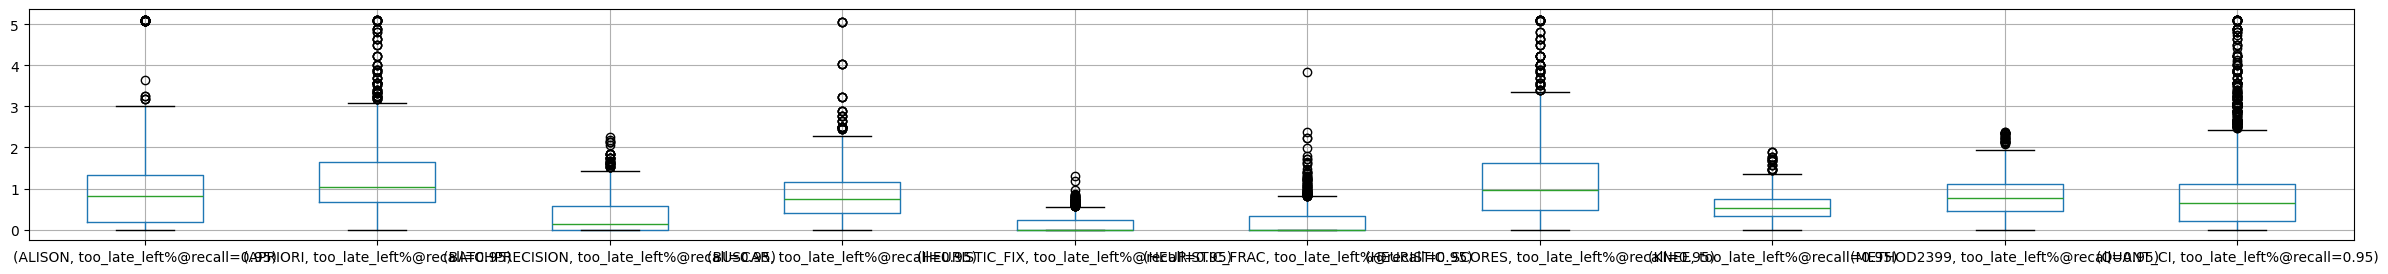

In [13]:
df_res.groupby('method').boxplot(subplots=False, column='too_late_left%@recall=0.95', figsize=(30, 3))

<Axes: >

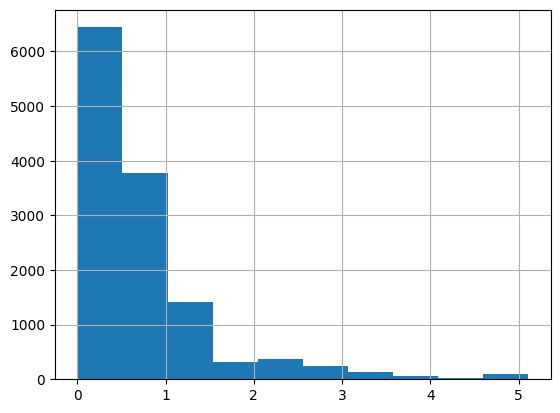

In [14]:
df_res['too_late_left%@recall=0.95'].hist()

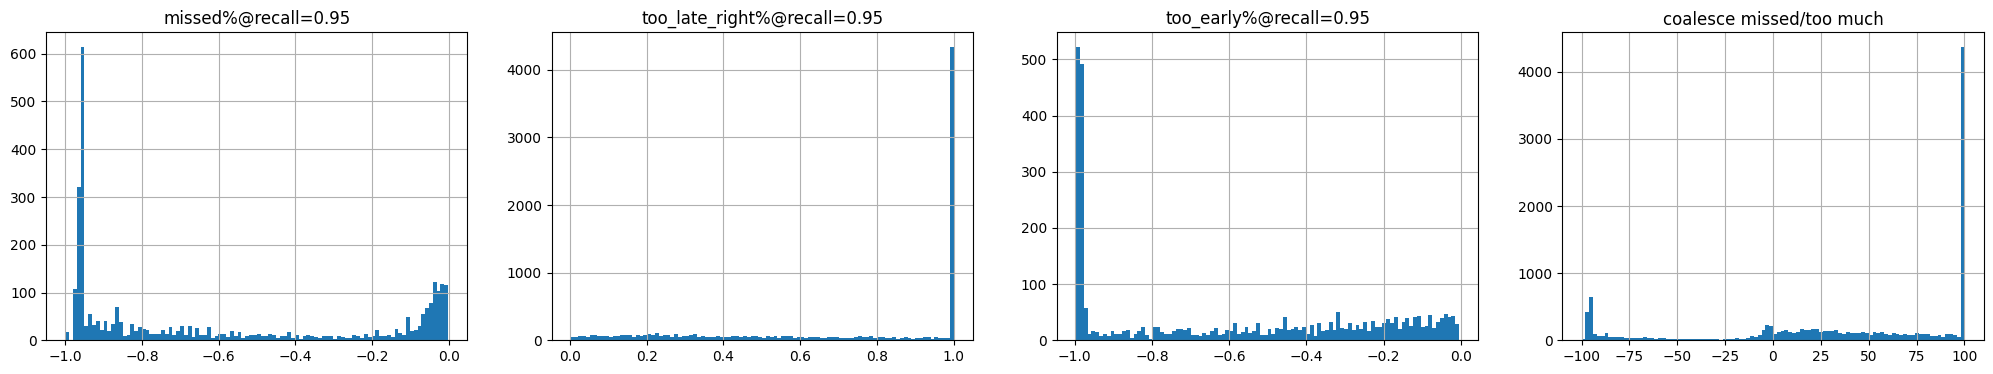

In [15]:
rt = 0.95
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 4))

late_ref = ['left', 'right'][1]

df_res['x'] = df_res[[f'too_late_{late_ref}%@recall={rt}', f'missed%@recall={rt}']].replace({0: np.nan}).bfill(axis=1).iloc[:, 0].fillna(0) * 100

ax1.set_title(f'missed%@recall={rt}')
df_res.loc[df_res[f'missed%@recall={rt}']<0, f'missed%@recall={rt}'].hist(bins=100, ax=ax1)
ax2.set_title(f'too_late_{late_ref}%@recall={rt}')
df_res.loc[df_res[f'too_late_{late_ref}%@recall={rt}']>0, f'too_late_{late_ref}%@recall={rt}'].hist(bins=100, ax=ax2)
ax3.set_title(f'too_early%@recall={rt}')
df_res.loc[df_res[f'too_early%@recall={rt}']<0, f'too_early%@recall={rt}'].hist(bins=100, ax=ax3)
ax4.set_title('coalesce missed/too much')
df_res['x'].hist(bins=100, ax=ax4)
df_res = df_res.drop(columns=['x'])

# Main figure

In [75]:
n_methods = len(df_res['method'].unique())
n_cols = 3
n_rows = (n_methods // n_cols) + 1
bins = 20
rt = 0.95

markers = ['x', '.', '+', 'o', 'v', '2', 'D', 's']
colours = ['red', 'green', 'blue', 'orange', 'pink']

def scattered(
      xval, xlab, xlim,
      yval, ylab, ylim,
      vred=False, hred=False,
      fname:str|None = None,
):  
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), dpi=120)
    xys = []
    hists_x, hists_y = {}, {}
    for meth in sorted(df_res['method'].unique()):
        print(meth)
        mask = df_res['method'] == meth
        df_meth = df_res[mask]
        rt_grp = False
        if meth in ['BUSCAR', 'ALISON', 'APRIORI', 'HEURISTIC_SCORES', 'HEURISTIC_RANDOM', 'CurveFitting', 'QUANT_CI']:
            group_col, groups = 'method-recall_target', {float(v_): f'{v_:.0%} recall target' for v_ in sorted(df_meth['method-recall_target'].unique())}
            rt_grp = True
        elif meth == 'BATCHPRECISION':
            group_col, groups = 'method-threshold', {float(v_): f'Threshold {v_:.0%}' for v_ in sorted(df_meth['method-threshold'].unique())}
        elif meth == 'HEURISTIC_FIX':
            group_col, groups = 'method-num_to_stop', {int(v_): f'{v_:,.0f} consecutive excl.' for v_ in sorted(df_meth['method-num_to_stop'].unique())}
        elif meth == 'HEURISTIC_FRAC':
            group_col, groups = 'method-fraction', {float(v_): f'{v_:.0%} consecutive excl.' for v_ in sorted(df_meth['method-fraction'].unique())}
        elif meth == 'KNEE':
            group_col, groups = 'method-threshold_peak', {float(v_): f'Knee threshold {v_:.0%}' for v_ in sorted(df_meth['method-threshold_peak'].unique())}
        elif meth == 'METHOD2399':
            group_col, groups = 'method-alpha', {float(v_): f'alpha={v_:.1f}' for v_ in sorted(df_meth['method-alpha'].unique())}
        #elif meth == 'QUANT_CI':
        #    group_col, groups = 'method-nstd', {float(v_): f'nstd={v_:.1f}' for v_ in sorted(df_meth['method-nstd'].unique())}
    
        for vi, (g, v) in enumerate(groups.items()):
            for rt_ in ([g] if rt_grp else RECALL_TARGETS):
                xy = (
                    df_meth[df_meth[group_col] == g]
                    .rename(columns={xval(rt_): 'x', yval(rt_): 'y'})
                    [['x', 'y']]
                    .assign(
                        xlabel=xlab,
                        ylabel=ylab,
                        method=meth,
                        glabel=v,
                        gval=g,
                    )
                )
    
            xys.append(xy)
    
    df_xy = pd.concat(xys)
    print(df_xy.shape)
    
    for mi, (meth, df_meth) in enumerate(df_xy.groupby('method')):
        print(meth, df_meth.shape)
        ax = axes[int(mi/n_cols)][mi%n_cols]
    
        #ax.set_aspect('equal')
        ax_histx = ax.inset_axes([0, 1.05, 1, 0.25])
        ax_histy = ax.inset_axes([1.05, 0, 0.25, 1])
    
        if vred:
            ax.fill_between(np.arange(len(df_meth)) - 100, 5, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, 10, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, 15, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, 20, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        if hred:
            ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -5, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -10, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -15, facecolor='red', alpha=0.1)
            ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -20, facecolor='red', alpha=0.1)
    
        histx, edgex = np.histogram(df_meth['x'], bins=bins, range=xlim)
        histy, edgey = np.histogram(df_meth['y'], bins=bins, range=ylim)
        hists_x[meth] = histx
        hists_y[meth] = histy
      
        ax_histx.bar(edgex[:-1], height=histx / histx.sum() * 100, width=(edgex[-1] - edgex[0]) / bins, alpha=0.2)
        ax_histy.barh(y=edgey[:-1], width=histy / histy.sum() * 100, height=(edgey[-1] - edgey[0]) / bins, alpha=0.2)
        
        for vi, (glabel, df_grp) in enumerate(df_meth.groupby('glabel')):
            ax.scatter(df_grp['x'], df_grp['y'], s=3, c=colours[vi], marker=markers[vi], label=glabel)
            
            histx, edgex = np.histogram(df_grp['x'], bins=bins, range=xlim)
            histy, edgey = np.histogram(df_grp['y'], bins=bins, range=ylim)
            ax_histx.plot(edgex[:-1], histx / histx.sum() * 100, alpha=0.5, c=colours[vi], marker=markers[vi], ms=3, lw=1)
            ax_histy.plot(histy / histy.sum() * 100, edgey[:-1], alpha=0.5, c=colours[vi], marker=markers[vi], ms=3, lw=1)
        
        #ax_histy.set_xscale('log')
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)
        #ax_histx.axis('off')
        #ax_histy.axis('off')
        ax.axes.xaxis.set_visible(True)
        ax.axes.yaxis.set_visible(True)
        ax.legend()
    
        ax.set_title(meth)
        ax.set_xlabel(df_meth.iloc[0]['xlabel'])
        ax.set_ylabel(df_meth.iloc[0]['ylabel'])
        ax.grid(lw=0.2, ls='--')
        ax_histx.grid(lw=0.2, ls='--')
        ax_histy.grid(lw=0.2, ls='--')
    
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax_histx.set_xlim(xlim)
        ax_histx.set_ylim(-5, 50)
        ax_histy.set_xlim(-5, 100)
        ax_histy.set_ylim(ylim)
    
    #fig.delaxes(axes[3][1])
    fig.delaxes(axes[3][2])
        
    fig.tight_layout()
    #fig.show()
    if fname is not None:
        fig.savefig(fname)

    df_hx = pd.DataFrame(hists_x | {xlab: edgex[:-1].astype(int)})
    df_hx_ = df_hx.iloc[:,0:-1].apply(lambda x: x/ x.sum()  * 100, axis=0).join(df_hx.iloc[:,-1])
    print(df_hx_.to_latex(index=False))
    display(df_hx_.style.background_gradient(cmap='Blues', axis=0))

    df_hy = pd.DataFrame(hists_y | {ylab: edgey[:-1].astype(int)})
    df_hy_ = df_hy.iloc[:,0:-1].apply(lambda y: y / y.sum()  * 100, axis=0).join(df_hy.iloc[:,-1])
    print(df_hy_.to_latex(index=False))
    display(df_hy_.style.background_gradient(cmap='Blues', axis=0))
    
    return fig, axes, df_hx, df_hy

ALISON
APRIORI
BATCHPRECISION
BUSCAR
HEURISTIC_FIX
HEURISTIC_FRAC
HEURISTIC_RANDOM
HEURISTIC_SCORES
KNEE
METHOD2399
QUANT_CI
(13773, 7)
ALISON (864, 7)
APRIORI (868, 7)
BATCHPRECISION (1953, 7)
BUSCAR (512, 7)
HEURISTIC_FIX (868, 7)
HEURISTIC_FRAC (1085, 7)
HEURISTIC_RANDOM (896, 7)
HEURISTIC_SCORES (868, 7)
KNEE (2604, 7)
METHOD2399 (651, 7)
QUANT_CI (2604, 7)
\begin{tabular}{rrrrrrrrrrrr}
\toprule
ALISON & APRIORI & BATCHPRECISION & BUSCAR & HEURISTIC_FIX & HEURISTIC_FRAC & HEURISTIC_RANDOM & HEURISTIC_SCORES & KNEE & METHOD2399 & QUANT_CI & % missed includes / % unused work-saving \\
\midrule
0.000000 & 0.000000 & 0.153610 & 0.000000 & 56.912442 & 58.709677 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & -105 \\
2.546296 & 0.000000 & 6.400410 & 0.000000 & 5.414747 & 3.778802 & 0.000000 & 0.000000 & 0.460829 & 0.000000 & 0.000000 & -94 \\
1.504630 & 0.000000 & 5.222734 & 0.000000 & 1.958525 & 1.658986 & 0.334821 & 0.000000 & 0.192012 & 0.153610 & 0.000000 & -84 \\
3.240741 &

,ALISON,APRIORI,BATCHPRECISION,BUSCAR,HEURISTIC_FIX,HEURISTIC_FRAC,HEURISTIC_RANDOM,HEURISTIC_SCORES,KNEE,METHOD2399,QUANT_CI,% missed includes / % unused work-saving
0,0.000000,0.000000,0.153610,0.000000,56.912442,58.709677,0.000000,0.000000,0.000000,0.000000,0.000000,-105
1,2.546296,0.000000,6.400410,0.000000,5.414747,3.778802,0.000000,0.000000,0.460829,0.000000,0.000000,-94
2,1.504630,0.000000,5.222734,0.000000,1.958525,1.658986,0.334821,0.000000,0.192012,0.153610,0.000000,-84
3,3.240741,0.115207,9.933436,0.000000,1.612903,1.198157,1.674107,0.345622,2.572965,2.457757,0.000000,-73
4,2.662037,1.036866,8.038914,0.000000,1.267281,0.829493,2.566964,1.382488,3.533026,3.840246,0.000000,-63
5,3.819444,1.612903,9.523810,0.000000,2.764977,1.013825,3.348214,1.497696,4.646697,2.918587,0.000000,-52
6,3.472222,1.497696,8.499744,0.000000,4.032258,2.949309,5.691964,2.995392,6.451613,5.683564,0.038402,-42
7,2.199074,1.267281,7.168459,0.000000,5.184332,4.792627,8.147321,3.110599,7.795699,5.683564,0.076805,-31
8,2.314815,0.806452,5.734767,0.000000,4.723502,5.253456,13.839286,3.917051,7.834101,6.144393,1.267281,-21
9,1.273148,0.691244,4.454685,0.000000,4.377880,3.963134,13.839286,3.341014,9.062980,3.993856,2.112135,-10


\begin{tabular}{rrrrrrrrrrrr}
\toprule
ALISON & APRIORI & BATCHPRECISION & BUSCAR & HEURISTIC_FIX & HEURISTIC_FRAC & HEURISTIC_RANDOM & HEURISTIC_SCORES & KNEE & METHOD2399 & QUANT_CI & Remaining after recall target \\
\midrule
24.537037 & 20.852535 & 45.161290 & 25.000000 & 45.161290 & 45.161290 & 21.763393 & 20.852535 & 45.161290 & 45.161290 & 20.852535 & 0 \\
25.925926 & 27.073733 & 26.728111 & 25.000000 & 26.728111 & 26.728111 & 26.785714 & 27.073733 & 26.728111 & 26.728111 & 27.073733 & 650 \\
8.333333 & 15.207373 & 5.990783 & 7.031250 & 5.990783 & 5.990783 & 15.178571 & 15.207373 & 5.990783 & 5.990783 & 15.207373 & 1300 \\
7.870370 & 5.299539 & 8.755760 & 7.812500 & 8.755760 & 8.755760 & 5.245536 & 5.299539 & 8.755760 & 8.755760 & 5.299539 & 1950 \\
9.259259 & 6.682028 & 3.686636 & 10.937500 & 3.686636 & 3.686636 & 6.473214 & 6.682028 & 3.686636 & 3.686636 & 6.682028 & 2600 \\
12.962963 & 8.064516 & 5.069124 & 15.625000 & 5.069124 & 5.069124 & 7.812500 & 8.064516 & 5.069124 & 5.0

,ALISON,APRIORI,BATCHPRECISION,BUSCAR,HEURISTIC_FIX,HEURISTIC_FRAC,HEURISTIC_RANDOM,HEURISTIC_SCORES,KNEE,METHOD2399,QUANT_CI,Remaining after recall target
0,24.537037,20.852535,45.161290,25.000000,45.161290,45.161290,21.763393,20.852535,45.161290,45.161290,20.852535,0
1,25.925926,27.073733,26.728111,25.000000,26.728111,26.728111,26.785714,27.073733,26.728111,26.728111,27.073733,650
2,8.333333,15.207373,5.990783,7.031250,5.990783,5.990783,15.178571,15.207373,5.990783,5.990783,15.207373,1300
3,7.870370,5.299539,8.755760,7.812500,8.755760,8.755760,5.245536,5.299539,8.755760,8.755760,5.299539,1950
4,9.259259,6.682028,3.686636,10.937500,3.686636,3.686636,6.473214,6.682028,3.686636,3.686636,6.682028,2600
5,12.962963,8.064516,5.069124,15.625000,5.069124,5.069124,7.812500,8.064516,5.069124,5.069124,8.064516,3250
6,2.777778,4.838710,0.921659,2.343750,0.921659,0.921659,4.687500,4.838710,0.921659,0.921659,4.838710,3900
7,2.777778,3.917051,1.382488,3.125000,1.382488,1.382488,3.906250,3.917051,1.382488,1.382488,3.917051,4550
8,0.462963,1.497696,1.382488,0.781250,1.382488,1.382488,1.562500,1.497696,1.382488,1.382488,1.497696,5200
9,0.462963,0.576037,0.460829,0.000000,0.460829,0.460829,0.669643,0.576037,0.460829,0.460829,0.576037,5850


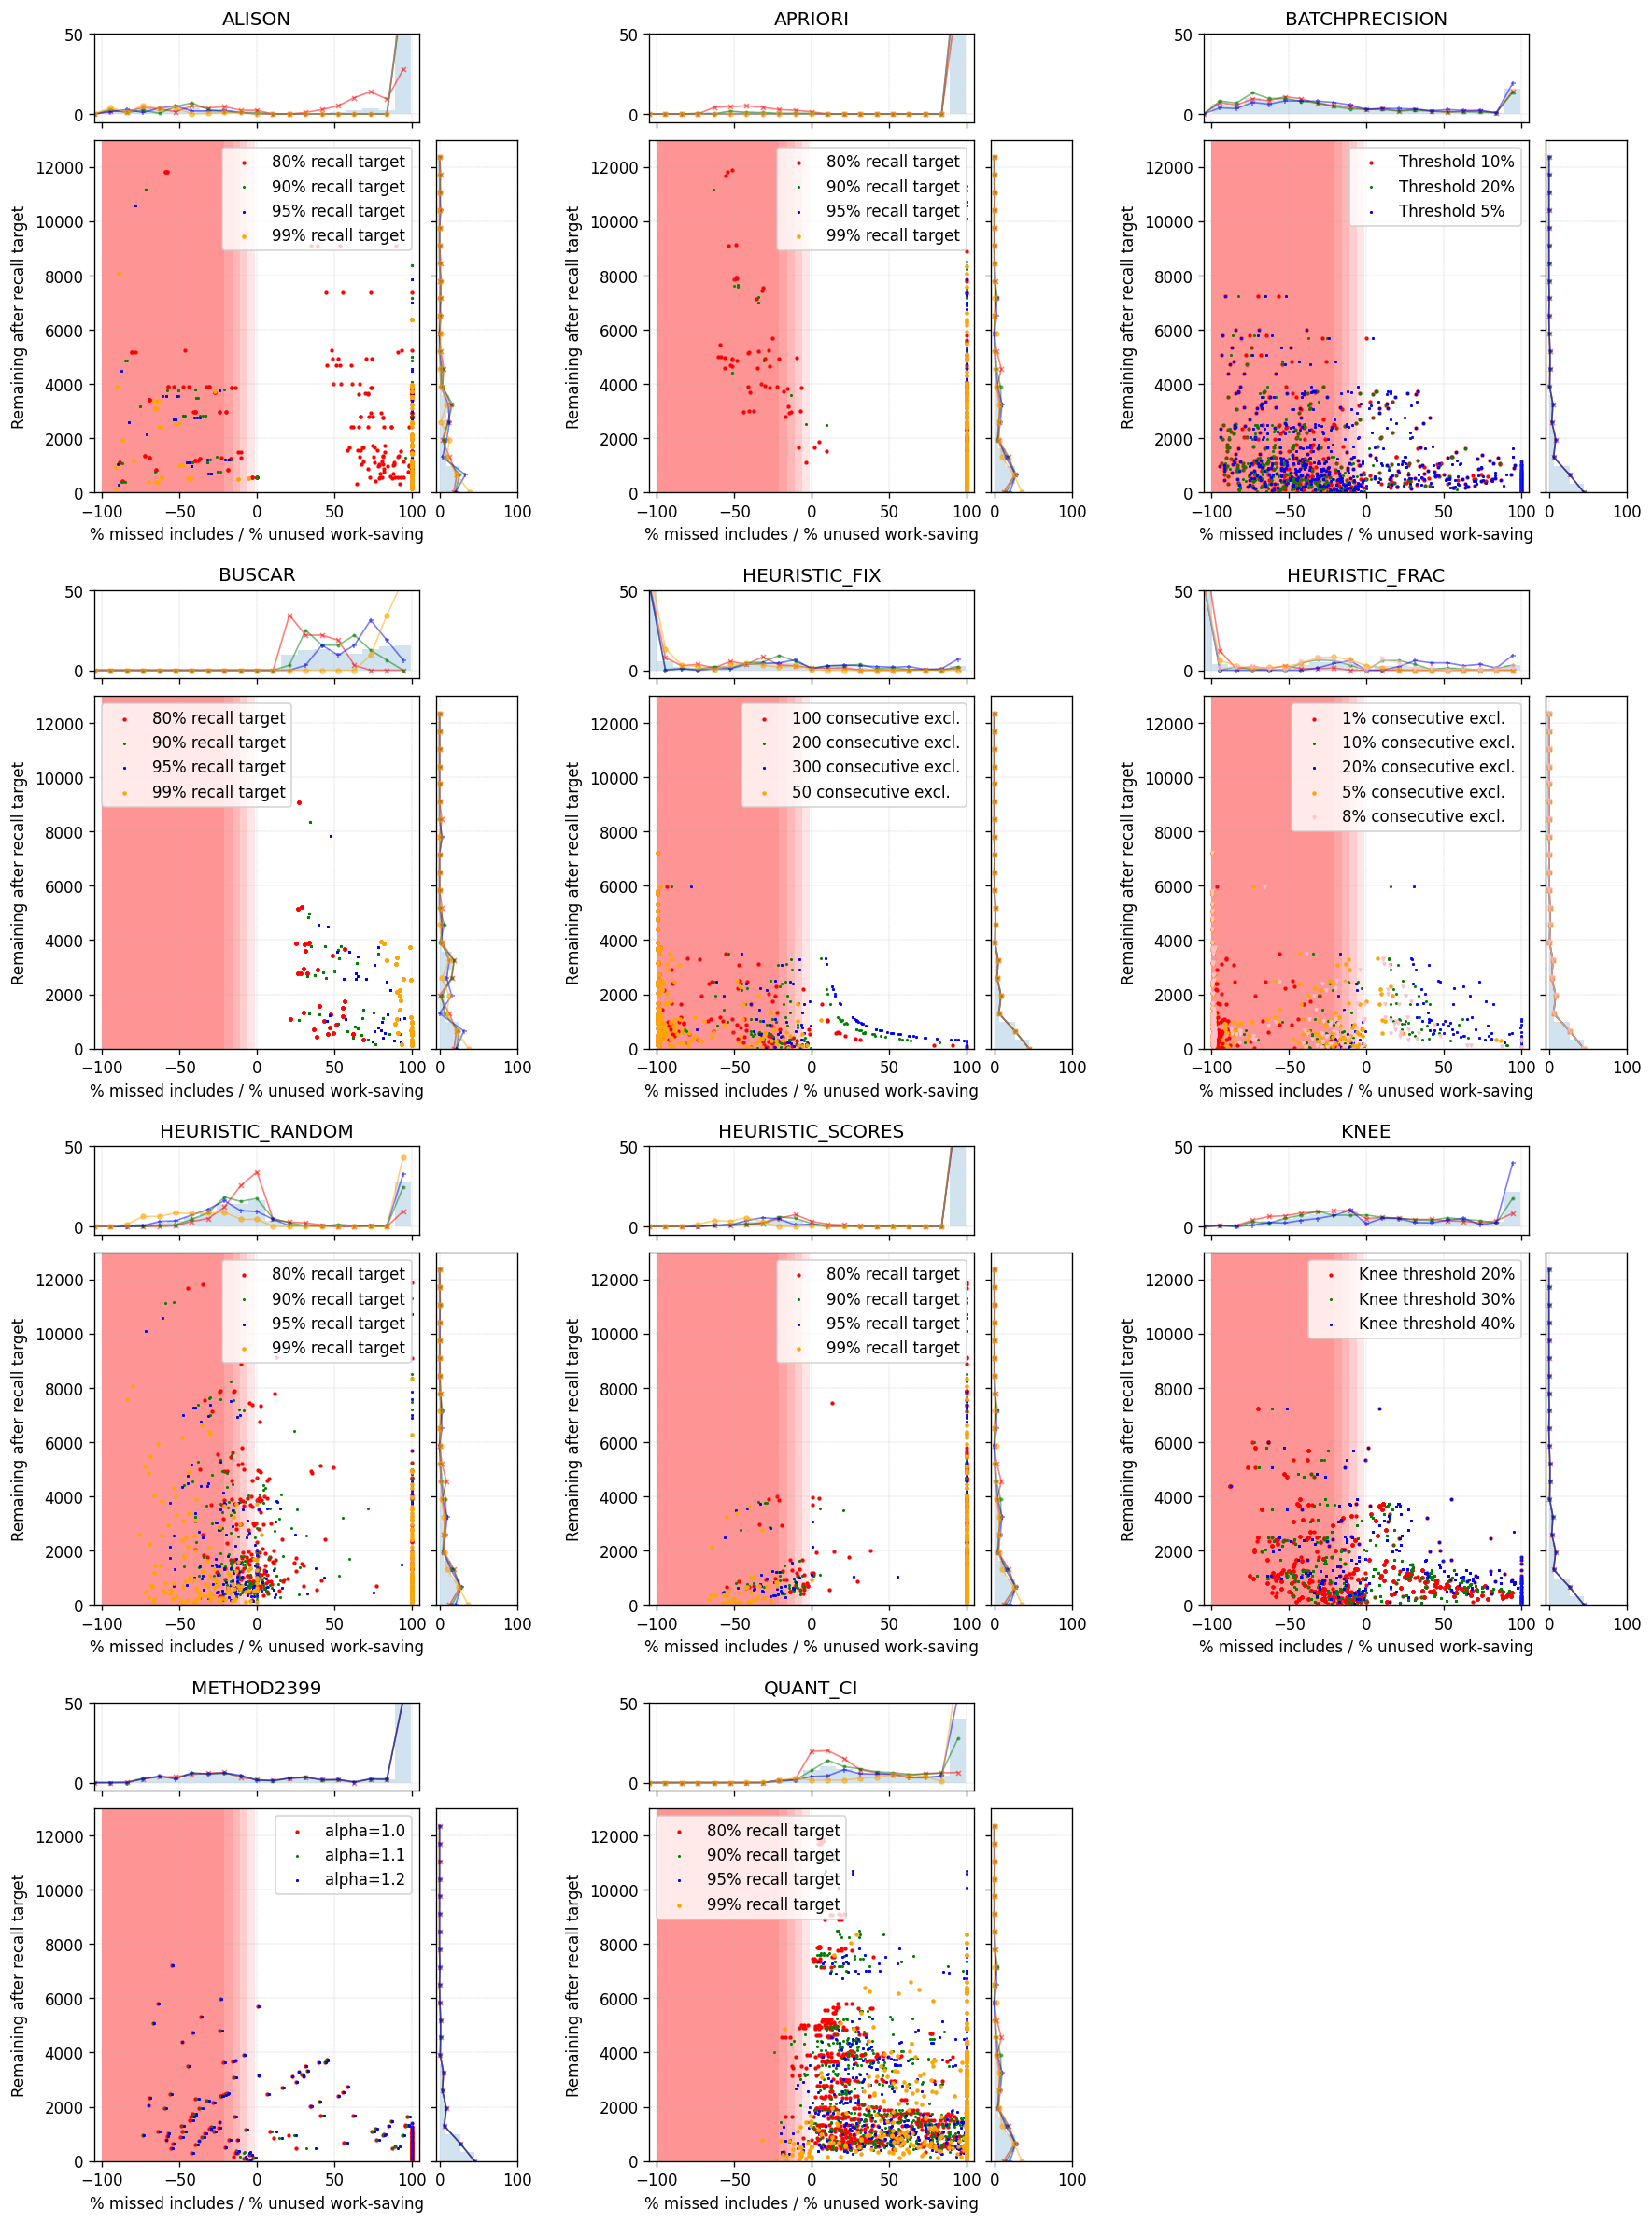

In [76]:
fig, _, df_hx, _ = scattered(
    xval=lambda x: f'tetl_right@recall={x}', xlab='% missed includes / % unused work-saving', xlim=(-105, 105),
    yval=lambda x: f'unseen@recall={x}', ylab='Remaining after recall target', ylim=(0, 13000),
    vred=False, hred=True,
    fname='../data/plots/scatter1.pdf',
)

ALISON
APRIORI
BATCHPRECISION
BUSCAR
HEURISTIC_FIX
HEURISTIC_FRAC
HEURISTIC_RANDOM
HEURISTIC_SCORES
KNEE
METHOD2399
QUANT_CI
(13773, 7)
ALISON (864, 7)
APRIORI (868, 7)
BATCHPRECISION (1953, 7)
BUSCAR (512, 7)
HEURISTIC_FIX (868, 7)
HEURISTIC_FRAC (1085, 7)
HEURISTIC_RANDOM (896, 7)
HEURISTIC_SCORES (868, 7)
KNEE (2604, 7)
METHOD2399 (651, 7)
QUANT_CI (2604, 7)
\begin{tabular}{rrrrrrrrrrrr}
\toprule
ALISON & APRIORI & BATCHPRECISION & BUSCAR & HEURISTIC_FIX & HEURISTIC_FRAC & HEURISTIC_RANDOM & HEURISTIC_SCORES & KNEE & METHOD2399 & QUANT_CI & % before/after recall target \\
\midrule
0.000000 & 0.000000 & 0.153610 & 0.000000 & 56.912442 & 58.709677 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & -105 \\
2.546296 & 0.000000 & 6.400410 & 0.000000 & 5.414747 & 3.778802 & 0.000000 & 0.000000 & 0.460829 & 0.000000 & 0.000000 & -94 \\
1.504630 & 0.000000 & 5.222734 & 0.000000 & 1.958525 & 1.658986 & 0.334821 & 0.000000 & 0.192012 & 0.153610 & 0.000000 & -84 \\
3.240741 & 0.115207 & 

,ALISON,APRIORI,BATCHPRECISION,BUSCAR,HEURISTIC_FIX,HEURISTIC_FRAC,HEURISTIC_RANDOM,HEURISTIC_SCORES,KNEE,METHOD2399,QUANT_CI,% before/after recall target
0,0.000000,0.000000,0.153610,0.000000,56.912442,58.709677,0.000000,0.000000,0.000000,0.000000,0.000000,-105
1,2.546296,0.000000,6.400410,0.000000,5.414747,3.778802,0.000000,0.000000,0.460829,0.000000,0.000000,-94
2,1.504630,0.000000,5.222734,0.000000,1.958525,1.658986,0.334821,0.000000,0.192012,0.153610,0.000000,-84
3,3.240741,0.115207,9.933436,0.000000,1.612903,1.198157,1.674107,0.345622,2.572965,2.457757,0.000000,-73
4,2.662037,1.036866,8.038914,0.000000,1.267281,0.829493,2.566964,1.382488,3.533026,3.840246,0.000000,-63
5,3.819444,1.612903,9.523810,0.000000,2.764977,1.013825,3.348214,1.497696,4.646697,2.918587,0.000000,-52
6,3.472222,1.497696,8.499744,0.000000,4.032258,2.949309,5.691964,2.995392,6.451613,5.683564,0.038402,-42
7,2.199074,1.267281,7.168459,0.000000,5.184332,4.792627,8.147321,3.110599,7.795699,5.683564,0.076805,-31
8,2.314815,0.806452,5.734767,0.000000,4.723502,5.253456,13.839286,3.917051,7.834101,6.144393,1.267281,-21
9,1.273148,0.691244,4.454685,0.000000,4.377880,3.963134,13.839286,3.341014,9.062980,3.993856,2.112135,-10


\begin{tabular}{rrrrrrrrrrrr}
\toprule
ALISON & APRIORI & BATCHPRECISION & BUSCAR & HEURISTIC_FIX & HEURISTIC_FRAC & HEURISTIC_RANDOM & HEURISTIC_SCORES & KNEE & METHOD2399 & QUANT_CI & % missed includes \\
\midrule
76.967593 & 92.972350 & 36.303123 & 100.000000 & 13.940092 & 18.433180 & 50.781250 & 83.410138 & 60.522273 & 74.039939 & 96.812596 & -5 \\
0.000000 & 0.230415 & 22.631848 & 0.000000 & 18.202765 & 14.930876 & 11.160714 & 0.345622 & 34.331797 & 22.119816 & 2.188940 & 0 \\
0.462963 & 0.115207 & 6.758833 & 0.000000 & 1.612903 & 0.829493 & 12.165179 & 2.995392 & 3.917051 & 2.457757 & 0.652842 & 6 \\
0.462963 & 0.460829 & 2.406554 & 0.000000 & 0.230415 & 0.092166 & 9.040179 & 1.612903 & 0.192012 & 1.382488 & 0.230415 & 11 \\
0.810185 & 0.576037 & 1.740911 & 0.000000 & 0.230415 & 0.184332 & 4.687500 & 1.843318 & 0.115207 & 0.000000 & 0.076805 & 17 \\
0.347222 & 0.460829 & 0.972862 & 0.000000 & 0.000000 & 0.000000 & 4.799107 & 2.304147 & 0.000000 & 0.000000 & 0.000000 & 22 \\
0.462

,ALISON,APRIORI,BATCHPRECISION,BUSCAR,HEURISTIC_FIX,HEURISTIC_FRAC,HEURISTIC_RANDOM,HEURISTIC_SCORES,KNEE,METHOD2399,QUANT_CI,% missed includes
0,76.967593,92.972350,36.303123,100.000000,13.940092,18.433180,50.781250,83.410138,60.522273,74.039939,96.812596,-5
1,0.000000,0.230415,22.631848,0.000000,18.202765,14.930876,11.160714,0.345622,34.331797,22.119816,2.188940,0
2,0.462963,0.115207,6.758833,0.000000,1.612903,0.829493,12.165179,2.995392,3.917051,2.457757,0.652842,6
3,0.462963,0.460829,2.406554,0.000000,0.230415,0.092166,9.040179,1.612903,0.192012,1.382488,0.230415,11
4,0.810185,0.576037,1.740911,0.000000,0.230415,0.184332,4.687500,1.843318,0.115207,0.000000,0.076805,17
5,0.347222,0.460829,0.972862,0.000000,0.000000,0.000000,4.799107,2.304147,0.000000,0.000000,0.000000,22
6,0.462963,1.036866,0.204813,0.000000,0.000000,0.000000,3.013393,1.612903,0.000000,0.000000,0.038402,28
7,0.810185,0.806452,0.768049,0.000000,0.000000,0.000000,1.450893,1.267281,0.000000,0.000000,0.000000,33
8,0.925926,1.267281,1.484895,0.000000,0.000000,0.000000,0.892857,0.691244,0.000000,0.000000,0.000000,39
9,1.273148,0.921659,1.024066,0.000000,0.000000,0.000000,0.446429,0.576037,0.000000,0.000000,0.000000,44


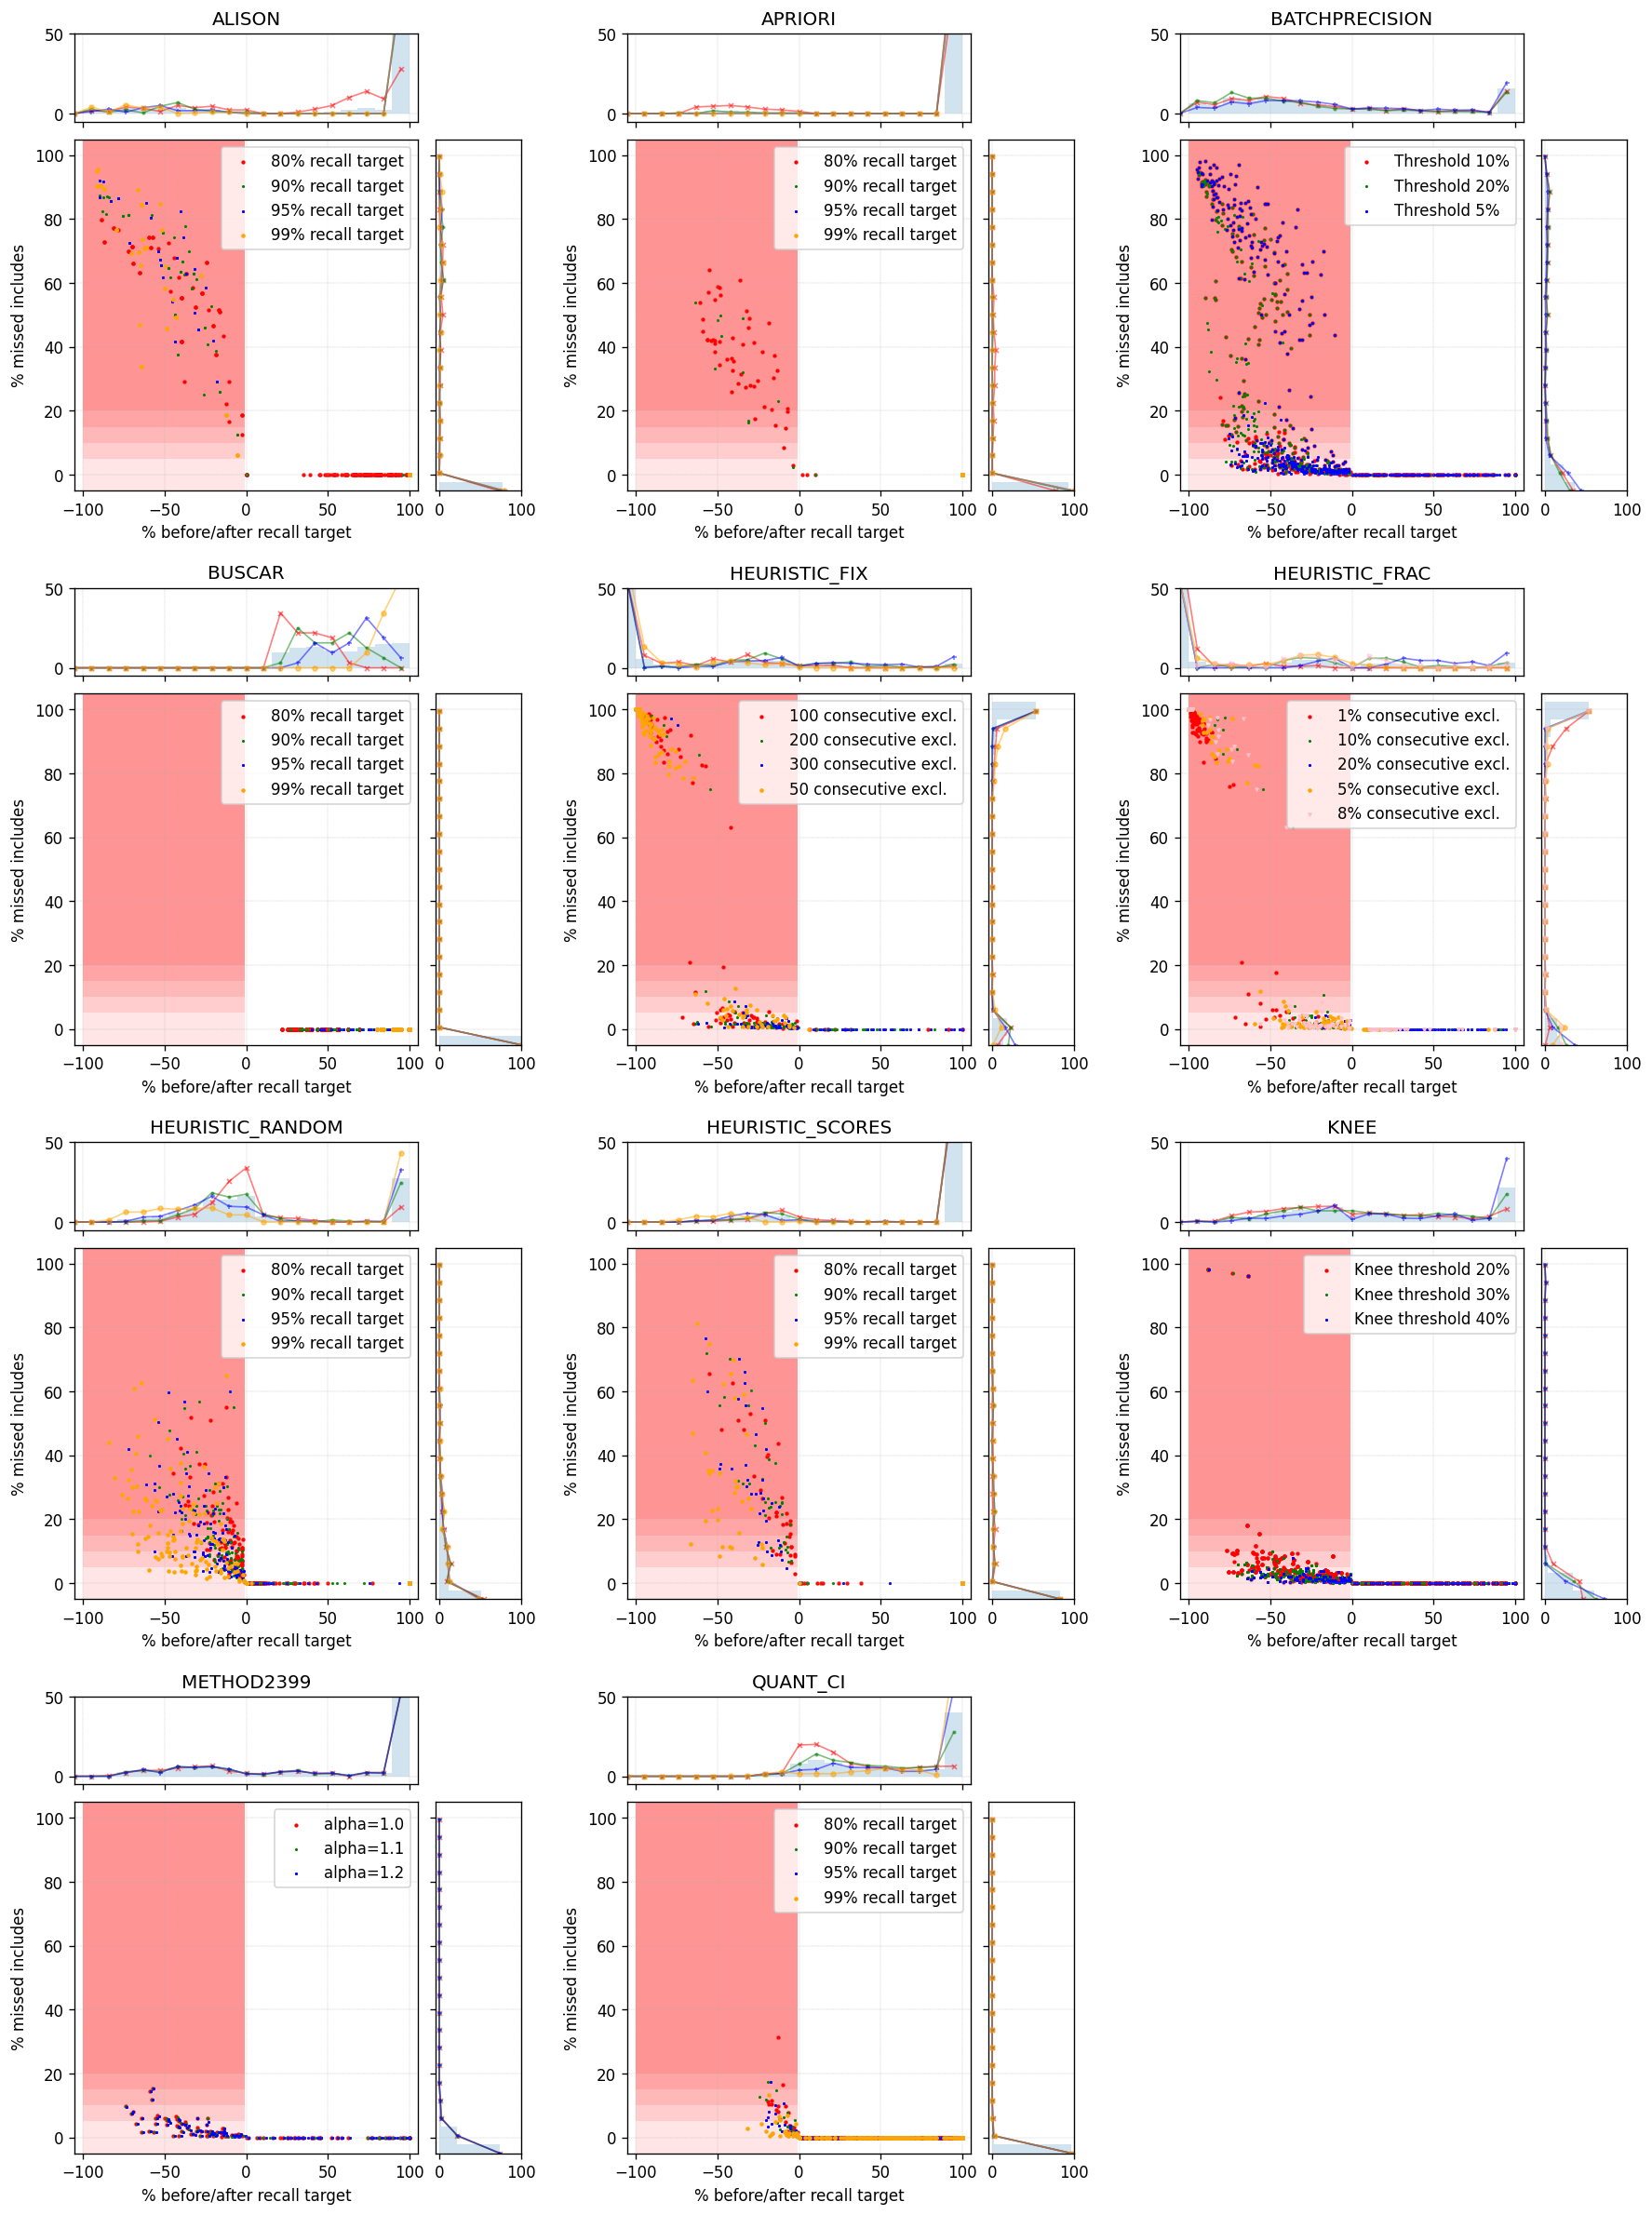

In [77]:
fig, _, _, _ = scattered(
    xval=lambda x: f'tetl_right@recall={x}', xlab='% before/after recall target', xlim=(-105, 105),
    yval=lambda x: f'missed_%@recall={x}', ylab='% missed includes', ylim=(-5, 105),
    vred=True, hred=False,
    fname='../data/plots/scatter2.pdf',
)

In [ ]:
#xval, xlab, xlim = ('work_saved', 'Work saved', (-0.1, 1.1))
#yval, ylab, ylim = ('stop_recall', 'Recall when stopped', (-0.1, 1.1))

#xval, xlab, xlim = ('x', '% missed includes / % additional work', (-105, 500))
#yval, ylab, ylim = ('stop_recall', 'Recall when stopped', (-0.1, 1.1))

#df_res['te'] = df_res[f'too_early%@recall={rt}'].fillna(0) * -100
#xval, xlab, xlim = ('x', '% missed includes / % additional work', (-105, 500))
#yval, ylab, ylim = ('te', '% stopped before target', (-5, 105))

#xval, xlab, xlim = (lambda x: f'tetl_right@recall={x}', '% missed includes / % unused work-saving',  (-105, 105)) # 400
#yval, ylab, ylim = (lambda x: 'n_total', 'Number of records', (0, 13000))

#xval, xlab, xlim = (f'missed%@recall={rt}', 'Missed', (-1.1, 0.1))
#yval, ylab, ylim = (f'too_late_{late_ref}%@recall={rt}', 'Overshoot', (-0.1, 5))

#fig, _, _, _ = scattered(
#    xval=lambda x: , xlab=, xlim=,
#    yval=lambda x: , ylab=, ylim=,
#    vred=True, hred=False,
#    fname='../data/plots/scatter1.pdf',
#)

# Numbers

In [74]:
df_ds = df[['dataset', 'n_total', 'n_incl', 'n_incl_seen']].groupby('dataset').first().reset_index()
df_ds['incl_rate'] = df_ds['n_incl'] / df_ds['n_total']
df_ds.describe()

,n_total,n_incl,n_incl_seen,incl_rate
count,86.000000,86.000000,86.000000,86.000000
mean,3573.918605,162.325581,0.674419,0.050351
std,2588.481395,233.723690,0.951060,0.051615
min,725.000000,16.000000,0.000000,0.008462
25%,1499.500000,53.500000,0.000000,0.019987
50%,2614.500000,103.000000,0.000000,0.034383
75%,4963.250000,188.750000,1.000000,0.062209
max,13095.000000,1957.000000,4.000000,0.370083


In [18]:
df_ds = df[['dataset', 'n_total', 'n_incl', 'n_incl_seen']].groupby('dataset').max().reset_index()
df_ds['incl_rate'] = df_ds['n_incl'] / df_ds['n_total']
df_ds.describe()

,n_total,n_incl,n_incl_seen,incl_rate
count,81.000000,81.000000,81.000000,81.000000
mean,3602.222222,167.086420,167.086420,0.050057
std,2570.583859,240.010635,240.010635,0.052197
min,1000.000000,16.000000,16.000000,0.008462
25%,1665.000000,53.000000,53.000000,0.019760
50%,2627.000000,105.000000,105.000000,0.033308
75%,4862.000000,189.000000,189.000000,0.060925
max,13095.000000,1957.000000,1957.000000,0.370083


In [39]:
(df_ds['n_total']<2399).sum()

np.int64(37)

In [ ]:
(df_ds['n_total']<2399).sum()

<Axes: >

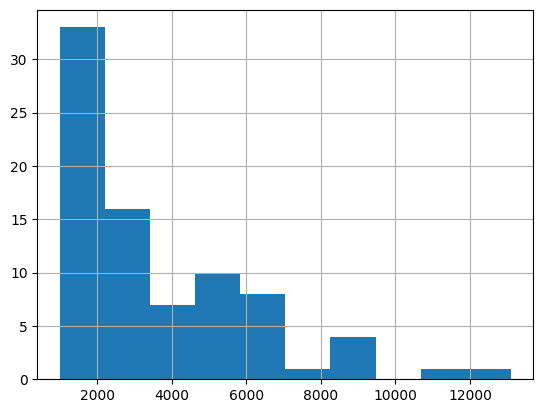

In [35]:
df_ds['n_total'].hist()

<Axes: >

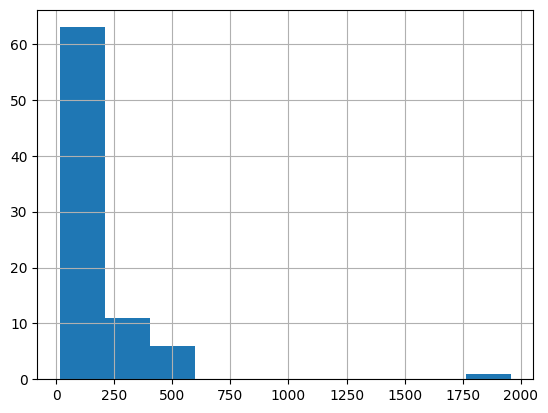

In [38]:
df_ds['n_incl'].hist()

<Axes: >

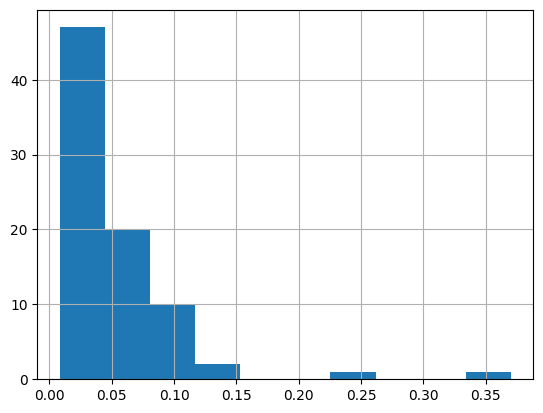

In [37]:
df_ds['incl_rate'].hist()

In [19]:
len(df.groupby(['sim_key', 'method-hash', 'sim-rep']))

12877

In [20]:
df.shape

(3019774, 43)

# Previous figure versions

In [ ]:
hists_y = {}
hists_x = {}

rt = 0.95  # recall target
bins = 20
late_ref = ['left', 'right'][1]

n_methods = len(df_res['method'].unique())
n_cols = 3
n_rows = (n_methods // n_cols)+1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), dpi=120)

markers = ['x', '.', '+', 'o', 'v', '2', 'D', 's']
colours = ['red', 'green', 'blue', 'orange', 'pink']

#xval, xlab, xlim = ('work_saved', 'Work saved', (-0.1, 1.1))
#yval, ylab, ylim = ('stop_recall', 'Recall when stopped', (-0.1, 1.1))

#xval, xlab, xlim = ('x', '% missed includes / % additional work', (-105, 500))
#yval, ylab, ylim = ('stop_recall', 'Recall when stopped', (-0.1, 1.1))

#df_res['te'] = df_res[f'too_early%@recall={rt}'].fillna(0) * -100
#xval, xlab, xlim = ('x', '% missed includes / % additional work', (-105, 500))
#yval, ylab, ylim = ('te', '% stopped before target', (-5, 105))

xval, xlab, xlab2, xlim = (lambda x: f'tetl_right@recall={x}', f'% missed includes / % unused work-saving (RT={rt:.0%})', '% missed includes / % unused work-saving',  (-105, 105)) # 400
yval, ylab, ylab2, ylim = (lambda x: 'n_total', 'Number of records', 'Number of records', (0, 13000))

#xval, xlab, xlab2, xlim = (lambda x: f'tetl_right@recall={x}', f'% before/after {rt:.0%} recall target', '% before/after recall target',  (-105, 105))
#yval, ylab, ylab2, ylim = (lambda x: f'missed_%@recall={x}', f'% missed includes (RT={rt:.0%})', '% missed includes',  (-5, 105))

#xval, xlab, xlim = (f'missed%@recall={rt}', 'Missed', (-1.1, 0.1))
#yval, ylab, ylim = (f'too_late_{late_ref}%@recall={rt}', 'Overshoot', (-0.1, 5))

vred = False
hred = True

for mi, meth in enumerate(sorted(df_res['method'].unique())):
    ax = axes[int(mi/n_cols)][mi%n_cols]
    mask = df_res['method'] == meth
    df_meth = df_res[mask]

   # ax.set_aspect('equal')
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.25])
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1])

    recall_targets = sorted(df_meth['method-recall_target'].unique())
    if len(recall_targets) > 1:
        group_col = 'method-recall_target'
        group_lab = lambda v_: f'{v_:.0%} recall target'
    elif meth == 'BATCHPRECISION':
        group_col = 'method-threshold'
        group_lab = lambda v_: f'Threshold {v_:.0%}'
    elif meth == 'HEURISTIC_FIX':
        group_col = 'method-num_to_stop'
        group_lab = lambda v_: f'{v_:,.0f} consecutive excl.'
    elif meth == 'HEURISTIC_FRAC':
        group_col = 'method-fraction'
        group_lab = lambda v_: f'{v_:.0%} consecutive excl.'
    elif meth == 'KNEE':
        group_col = 'method-threshold_peak'
        group_lab = lambda v_: f'Knee threshold {v_:.0%}'
    elif meth == 'METHOD2399':
        group_col = 'method-alpha'
        group_lab = lambda v_: f'alpha={v_:.1f}'
    else:
        group_col = None

    if vred:
        ax.fill_between(np.arange(len(df_meth)) - 100, 5, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, 10, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, 15, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, 20, ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
    if hred:
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < 0, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -5, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -10, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -15, facecolor='red', alpha=0.1)
        ax.fill_between(np.arange(len(df_meth)) - 100, ylim[0], ylim[1], where=(np.arange(len(df_meth))-100) < -20, facecolor='red', alpha=0.1)

    if len(recall_targets) <= 1:
        histx, edgex = np.histogram(df_meth[xval(rt)], bins=bins, range=xlim)
        histy, edgey = np.histogram(df_meth[yval(rt)], bins=bins, range=ylim)
        hists_x[meth] = histx
        hists_y[meth] = histy
      
        ax_histx.bar(edgex[:-1], height=histx / histx.sum() * 100, width=(edgex[-1] - edgex[0]) / bins, alpha=0.2)
        ax_histy.barh(y=edgey[:-1], width=histy / histy.sum() * 100, height=(edgey[-1] - edgey[0]) / bins, alpha=0.2)
    
    if group_col is None:
        df_meth.plot.scatter(x=xval, y=yval, ax=ax, s=1)
    else:
        values = sorted(df_meth[group_col].unique())
        for vi, v in enumerate(values):
            xy = df_meth[df_meth[group_col] == v].rename(columns={xval(v if len(recall_targets) > 1 else rt): 'x', yval(v if len(recall_targets) > 1 else rt): 'y'})[['x', 'y']]
            ax.scatter(xy['x'], xy['y'], s=3, c=colours[vi], marker=markers[vi], label=group_lab(v))

            histx, edgex = np.histogram(df_meth[df_meth[group_col] == v][xval(v if len(recall_targets) > 1 else rt)], bins=bins, range=xlim)
            histy, edgey = np.histogram(df_meth[df_meth[group_col] == v][yval(v if len(recall_targets) > 1 else rt)], bins=bins, range=ylim)
            ax_histx.plot(edgex[:-1], histx / histx.sum() * 100, alpha=0.5, c=colours[vi], marker=markers[vi], ms=3, lw=1)
            ax_histy.plot(histy / histy.sum() * 100, edgey[:-1], alpha=0.5, c=colours[vi], marker=markers[vi], ms=3, lw=1)
        
           # xhist = np.linspace(xlim[0], xlim[1], bins)
           # xv = df_meth[df_meth[group_col] == v][xval]
           # gx = gaussian_kde(xv)(xhist) if np.var(xv) > 0 else np.ones_like(xhist) * xv.mean()
           # ax_histx.plot(xhist, gx / (gx + 1e-6).sum(), alpha=0.5, c=colours[vi], marker=markers[vi])
           # yhist = np.linspace(ylim[0], ylim[1], bins)
           # yv = df_meth[df_meth[group_col] == v][yval]
           # gy = gaussian_kde(yv)(yhist) if np.var(yv) > 0 else np.ones_like(yhist) * yv.mean()
           # ax_histy.plot(gy / (gy + 1e-6).sum(), yhist, alpha=0.5, c=colours[vi], marker=markers[vi])
        ax.legend()
    #ax_histy.set_xscale('log')
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)
    
    ax.set_title(meth)
    ax.set_xlabel(xlab if len(recall_targets) <= 1 else xlab2)
    ax.set_ylabel(ylab if len(recall_targets) <= 1 else ylab2)
    ax.grid(lw=0.2, ls='--')
    ax_histx.grid(lw=0.2, ls='--')
    ax_histy.grid(lw=0.2, ls='--')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax_histx.set_xlim(xlim)
    ax_histx.set_ylim(-5, 50)
    ax_histy.set_xlim(-5, 100)
    ax_histy.set_ylim(ylim)

fig.delaxes(axes[3][2])
fig.delaxes(axes[3][1])
    
fig.tight_layout()
#fig.show()
#fig.savefig('../data/plots/scatter.pdf')

In [ ]:
fig.savefig('../data/plots/scatter.pdf')

In [ ]:
pd.DataFrame(hists_y | {'Recall': edgey[:-1]}).style.background_gradient(cmap='Blues', axis=0)

In [ ]:
pd.DataFrame(hists_x | {'Work saved': edgex[:-1]}).style.background_gradient(cmap='Blues', axis=0)

In [ ]:
df_res[(df_res['method'] == 'BUSCAR') & (df_res['stop_recall'] < 0.9)]

In [ ]:
hists_y = {}
hists_x = {}

n_methods = len(df_res['method'].unique())
n_cols = 3
n_rows = (n_methods // n_cols)+1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), dpi=120)

markers = ['x', '.', '+', 'o', 'v', '2', 'D', 's']
colours = ['red', 'green', 'blue', 'orange', 'pink']

xval = 'work_saved'
xlab = 'Work saved'
for mi, meth in enumerate(sorted(df_res['method'].unique())):
    ax = axes[int(mi/n_cols)][mi%n_cols]
    mask = df_res['method'] == meth
    df_meth = df_res[mask]
    
    ax.set_aspect('equal')
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.25])
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1])


    ax.set_title(meth)
    ax.set_ylabel('Recall when stopped')
    ax.set_xlabel(xlab)
    ax.grid(lw=0.2, ls='--')
    
    bins = 20
    binwidth = 1 / bins
    bins = np.arange(0, 1 + binwidth, binwidth)
    
    recall_targets = sorted(df_meth['method-recall_target'].unique())
    if len(recall_targets) > 1:
        for rti, rt in enumerate(recall_targets):
            df_meth[df_meth['method-recall_target'] == rt].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[rti], marker=markers[rti], label=f'{rt:.0%} recall target')
        ax.legend()
    elif meth == 'BATCHPRECISION':
        thresholds = sorted(df_meth['method-threshold'].unique())
        for thi, th in enumerate(thresholds):
            df_meth[df_meth['method-threshold'] == th].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[thi], marker=markers[thi], label=f'Threshold {th:.0%}')
        ax.legend()
    elif meth == 'HEURISTIC_FIX':
        values = sorted(df_meth['method-num_to_stop'].unique())
        for vi, v in enumerate(values):
            df_meth[df_meth['method-num_to_stop'] == v].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[vi], marker=markers[vi], label=f'{v:,.0f} consecutive excl.')
    elif meth == 'HEURISTIC_FRAC':
        values = sorted(df_meth['method-fraction'].unique())
        for vi, v in enumerate(values):
            df_meth[df_meth['method-fraction'] == v].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[vi], marker=markers[vi], label=f'{v:.0%} consecutive excl.')
        ax.legend()
    elif meth == 'KNEE':
        values = sorted(df_meth['method-threshold_peak'].unique())
        for vi, v in enumerate(values):
            df_meth[df_meth['method-threshold_peak'] == v].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[vi], marker=markers[vi], label=f'Knee threshold {v:.0%}')
        ax.legend()
    elif meth == 'METHOD2399':
        values = sorted(df_meth['method-alpha'].unique())
        for vi, v in enumerate(values):
            df_meth[df_meth['method-alpha'] == v].plot.scatter(x=xval, y='stop_recall', ax=ax, s=3, c=colours[vi], marker=markers[vi], label=f'alpha={v:.1f}')
        ax.legend()
    else:
        df_meth.plot.scatter(x=xval, y='stop_recall', ax=ax, s=1)

    histx, _ = np.histogram(df_meth[xval], bins=bins)
    histy, _ = np.histogram(df_meth['stop_recall'], bins=bins)
    ax_histx.bar(bins[:-1], height=histx / histx.sum(), width=binwidth)
    ax_histy.barh(y=bins[:-1], width=histy / histy.sum(), height=binwidth)
    
    hists_x[meth] = histx
    hists_y[meth] = histy

    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax.axes.xaxis.set_visible(True)
    ax.axes.yaxis.set_visible(True)

    
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(-0.1, 1.1)
    ax_histx.set_xlim(-0.1, 1.1)
    ax_histx.set_ylim(-0.1, 1.1)
    ax_histy.set_xlim(-0.1, 1.1)
    ax_histy.set_ylim(-0.1, 1.1)

fig.delaxes(axes[3][2])
fig.delaxes(axes[3][1])
    
fig.tight_layout()
#fig.show()

In [ ]:
df_res[df_res['method'] == 'BUSCAR'].plot.scatter(x='work_saved', y='stop_recall')

In [ ]:
df_res[df_res['method'] == 'BUSCAR'].plot.scatter(x='method-recall_target', y='stop_recall')

In [ ]:
plots = df_res.groupby('method').plot.scatter(x='te', y='n_total')
fig, axes = plt.subplots(4, 3)
for i, (m, p) in enumerate(plots.items()):
    axes[i//3][i%3].axes(p)
    p.set_title(m)


In [ ]:
df.head()

In [ ]:
df.groupby('dataset').first()['n_total'].hist()

In [ ]:
df_meth